# "[DACON] 쇼핑물 매출액 예측 경진대회"
- author: Seong Yeon Kim 
- categories: [DACON, jupyter, EDA, Regression] 
- image: images/220723.png

# 데이터 불러오기

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


개인 구글 드라이브에 파일을 업로드 한뒤 코렙 계정과 연동합니다.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

path = '/content/drive/MyDrive/shop/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


데이터 분석에 필요한 필수 패키지를 설치하고 데이터를 불러옵니다.

In [96]:
print(train.shape)
print(test.shape)

(6255, 13)
(180, 12)


칼럼 개수는 총 12개, 트레인 데이터는 6255개, 테스트 데이터는 180개 입니다. 트레인 데이터가 어느정도 있습니다.

# 반응 변수 분석

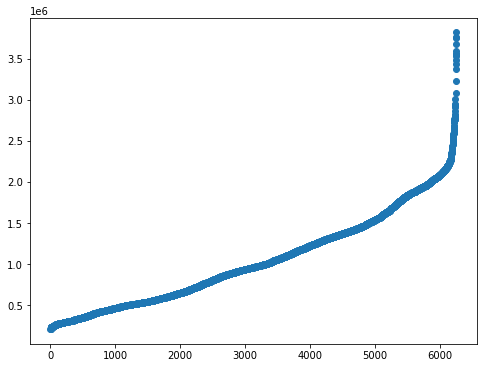

In [97]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['Weekly_Sales'].values))
plt.show()

데이터 분석시 가장 먼저 반응변수 형태를 분석해야합니다. 매출액 데이터이기 때문에 튀는 값이 다소 관찰됩니다.

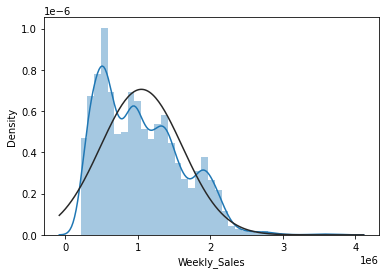

In [98]:
sns.distplot(train['Weekly_Sales'], fit=stats.norm)

반응변수의 히스토그램과 만약 정규분포일 때 히스토그램을 비교했습니다.

정규분포와 비교했을 때 오른쪽 꼬리가 다소 길어보입니다.

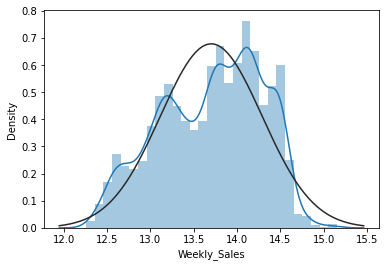

In [99]:
sns.distplot(np.log1p(train['Weekly_Sales']), fit=stats.norm)

로그변환시 이전보다 확실히 정규분포에 가까워졌습니다.

In [100]:
#train['Weekly_Sales'] = np.log1p(train['Weekly_Sales'])

# 변수 전처리

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


데이터를 전반적으로 살펴보고 결측치 여부 또한 알아봅니다. Promotion 변수 5개가 결측값이 상당하네요.

In [102]:
import datetime

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train['Year'] = train['Date'].dt.year 
train['Month'] = train['Date'].dt.month 

test['Year'] = test['Date'].dt.year 
test['Month'] = test['Date'].dt.month

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Year,Month
0,1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90,2010,5
1,2,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44,2010,12
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17,2010,2
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59,2010,2
4,5,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68,2010,5


파이썬 내 datetime를 임포트하고 Date 값을 datetime으로 변환하면 손쉽게 날짜 데이터를 다룰수 있습니다.

여기서 날짜 데이터의 연과 월 값을 간편하게 뽑아냈습니다.

In [103]:
print(sum(train['Promotion1'] < 0))
print(sum(train['Promotion2'] < 0))
print(sum(train['Promotion3'] < 0))
print(sum(train['Promotion4'] < 0))
print(sum(train['Promotion5'] < 0))

0
18
4
0
0


Promotion 값이 0 미만인게 혹시 있는지 확인 했습니다. 일부 관측되는 것으로 보입니다.

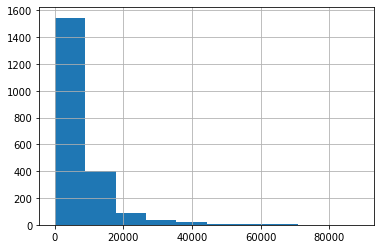

In [104]:
train['Promotion1'].hist()

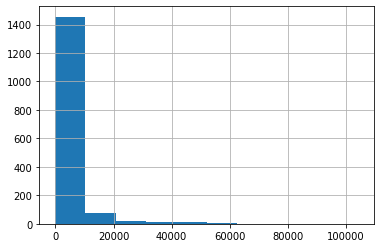

In [105]:
train['Promotion2'].hist()

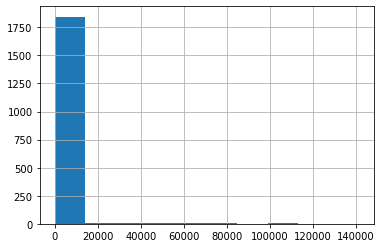

In [106]:
train['Promotion3'].hist()

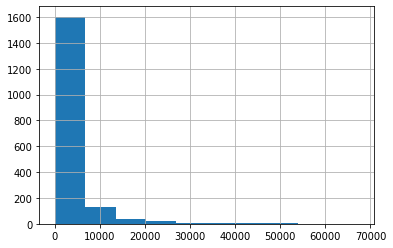

In [107]:
train['Promotion4'].hist()

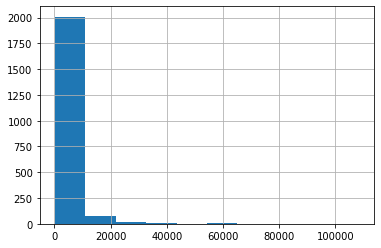

In [108]:
train['Promotion5'].hist()

Promotion 변수의 히스토그램 5개를 확인했습니다. 대부분 작은 값을 가지고 있으나 일부 값이 극단적으로 만 단위를 넘어갑니다.

정말 가끔씩 0 이하의 값도 존재하고 만이 넘어가는 값도 있고 결측값도 상당히 많아 어떤 변수인지 추측하기 어렵습니다.

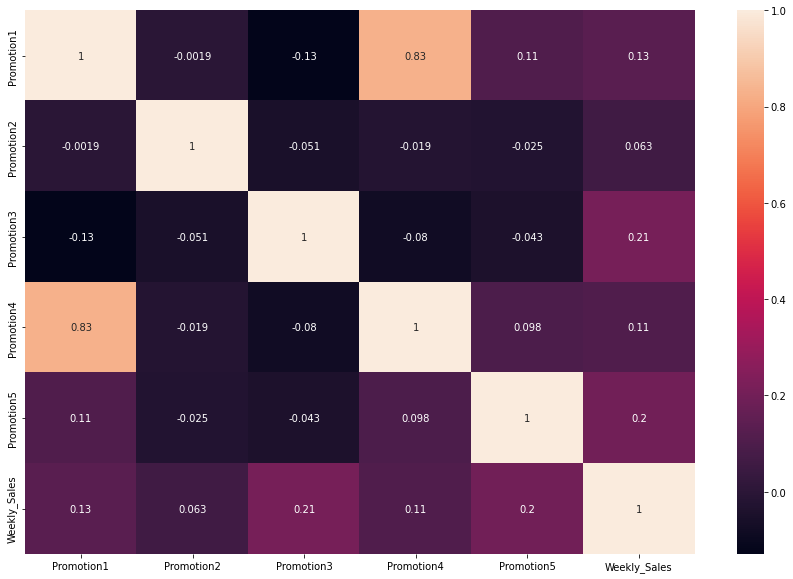

In [109]:
tem = train.dropna()

promotion = ['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']

plt.figure(figsize=(15,10))
ax = sns.heatmap(tem[promotion + ['Weekly_Sales']].corr(), annot=True)
plt.show()

프로모션 변수를 더 관찰하기 위해 결측값이 있는 데이터는 제외하고 상관관계를 살펴보았습니다.

프로모션1과 프로모션4가 연관이 상당히 있으며 프로모션2를 제외하곤 타겟값에 긍정적인 영향을 일부 끼친다고 볼 수 있습니다.

즉 유의미한 변수이긴 하다라고 생각해야겠네요.

In [110]:
print(tem['Weekly_Sales'].mean())
print(train['Weekly_Sales'].mean())

1243139.141739766
1047619.073811351


그럼 프로모션 변수가 결측값인 것은 의미가 있을까가 궁금했는데요.

프로모션 변수가 결측값이 아닌 데이터의 타겟값 평균이 전체 데이터의 타겟값 평균보다 꽤 큰 것을 알 수 있습니다.

In [111]:
train[train['Year'] == 2010].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 6163
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            2160 non-null   int64         
 1   Store         2160 non-null   int64         
 2   Date          2160 non-null   datetime64[ns]
 3   Temperature   2160 non-null   float64       
 4   Fuel_Price    2160 non-null   float64       
 5   Promotion1    0 non-null      float64       
 6   Promotion2    0 non-null      float64       
 7   Promotion3    0 non-null      float64       
 8   Promotion4    0 non-null      float64       
 9   Promotion5    0 non-null      float64       
 10  Unemployment  2160 non-null   float64       
 11  IsHoliday     2160 non-null   bool          
 12  Weekly_Sales  2160 non-null   float64       
 13  Year          2160 non-null   int64         
 14  Month         2160 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64

2010년 데이터입니다. 프로모션 변수는 모두 결측값입니다.

In [112]:
train[train['Year'] == 2011].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 48 to 6215
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            2340 non-null   int64         
 1   Store         2340 non-null   int64         
 2   Date          2340 non-null   datetime64[ns]
 3   Temperature   2340 non-null   float64       
 4   Fuel_Price    2340 non-null   float64       
 5   Promotion1    354 non-null    float64       
 6   Promotion2    293 non-null    float64       
 7   Promotion3    342 non-null    float64       
 8   Promotion4    302 non-null    float64       
 9   Promotion5    360 non-null    float64       
 10  Unemployment  2340 non-null   float64       
 11  IsHoliday     2340 non-null   bool          
 12  Weekly_Sales  2340 non-null   float64       
 13  Year          2340 non-null   int64         
 14  Month         2340 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float6

2011년 데이터입니다. 프로모션 변수는 대부분 결측값이네요.

In [113]:
train[train['Year'] == 2012].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1755 entries, 100 to 6254
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1755 non-null   int64         
 1   Store         1755 non-null   int64         
 2   Date          1755 non-null   datetime64[ns]
 3   Temperature   1755 non-null   float64       
 4   Fuel_Price    1755 non-null   float64       
 5   Promotion1    1748 non-null   float64       
 6   Promotion2    1299 non-null   float64       
 7   Promotion3    1543 non-null   float64       
 8   Promotion4    1517 non-null   float64       
 9   Promotion5    1755 non-null   float64       
 10  Unemployment  1755 non-null   float64       
 11  IsHoliday     1755 non-null   bool          
 12  Weekly_Sales  1755 non-null   float64       
 13  Year          1755 non-null   int64         
 14  Month         1755 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float

2012년 데이터입니다. 프로모션 변수는 대부분 결측값이 아닙니다.

2011년 특정 시점부터 프로모션 변수를 체크하기 시작됬다고 생각할 수 있습니다.

In [114]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

train['Promotion1'][train['Promotion1'] < 0] = 0
train['Promotion2'][train['Promotion2'] < 0] = 0
train['Promotion3'][train['Promotion3'] < 0] = 0
train['Promotion4'][train['Promotion4'] < 0] = 0
train['Promotion5'][train['Promotion5'] < 0] = 0

test['Promotion1'][test['Promotion1'] < 0] = 0
test['Promotion2'][test['Promotion2'] < 0] = 0
test['Promotion3'][test['Promotion3'] < 0] = 0
test['Promotion4'][test['Promotion4'] < 0] = 0
test['Promotion5'][test['Promotion5'] < 0] = 0


train['Promotion1'] = np.log1p(train['Promotion1'])
train['Promotion2'] = np.log1p(train['Promotion2'])
train['Promotion3'] = np.log1p(train['Promotion3'])
train['Promotion4'] = np.log1p(train['Promotion4'])
train['Promotion5'] = np.log1p(train['Promotion5'])

test['Promotion1'] = np.log1p(test['Promotion1'])
test['Promotion2'] = np.log1p(test['Promotion2'])
test['Promotion3'] = np.log1p(test['Promotion3'])
test['Promotion4'] = np.log1p(test['Promotion4'])
test['Promotion5'] = np.log1p(test['Promotion5'])

프로모션 변수가 결측값이 아닐때 타겟값이 커진다는 사실에 기반해 결측값인 경우 0으로 채워넣었습니다.

또 프로모션 변수는 값이 극단적으로 큰 경우가 나오기 때문에 로그변환을 했습니다.

이때 0보다 작은 값은 로그변환시 좋지 않으므로 모두 0으로 바꾼 뒤 로그변환을 했습니다.

# 변수 관찰

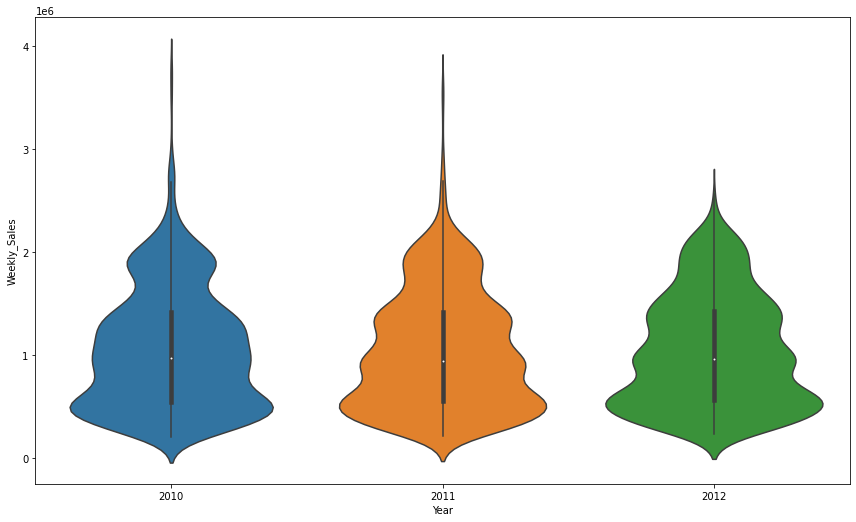

In [117]:
def discrete_plot(variable):    
    plt.figure(figsize=(12,8))
    sns.violinplot(x= train[variable], y= train['Weekly_Sales'])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

discrete_plot('Year')

연도 변수별 매출액 그래프 입니다. 매해 비슷한 모습을 보입니다. 다만 2010, 2011년 매출액 피크지점이 다소 높아보이네요.

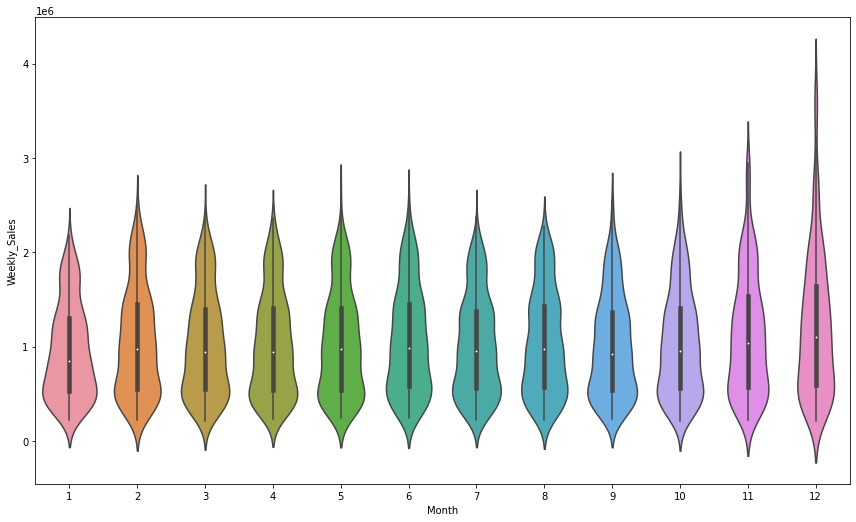

In [118]:
discrete_plot('Month')

달별 매출액 그래프 입니다. 평균값이 달마다 조금씩 차이나 보입니다. 12월달이 역시 매출이 잘 나오네요.

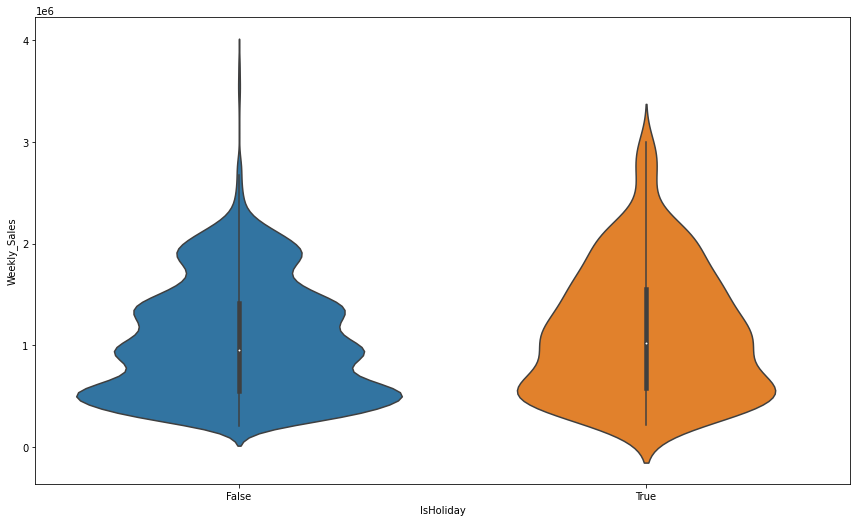

In [138]:
discrete_plot('IsHoliday')

공휴일 여부에 따른 매출액 분포입니다. 크진 않으나 약간의 차이가 보이네요.

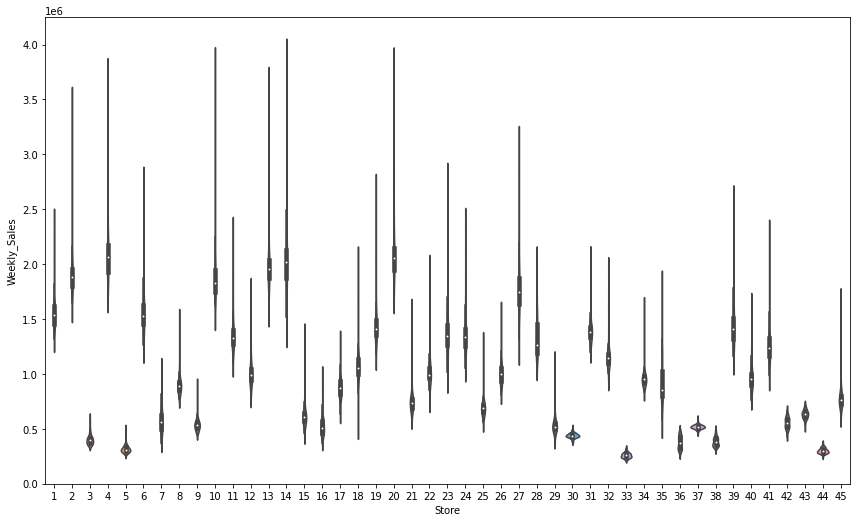

In [141]:
discrete_plot('Store')

매장 별 매출액 차이입니다. 사실 매장별로 매출액의 분포가 큰 폭으로 다른 것은 상식적으로 당연합니다.

분석시 유의사항으로 매장들이 현재 숫자형 값으로 입력되어있는데 순서형 자료로 분석되서는 절때 안됩니다.

매장 종류가 45가지나 되므로 트리모델을 사용하던, 회귀모형을 사용하던 1~45 값 그대로 넣는 것은 위험합니다.

모델에 넣기 전 원-핫 인코딩을 수행하겠습니다.

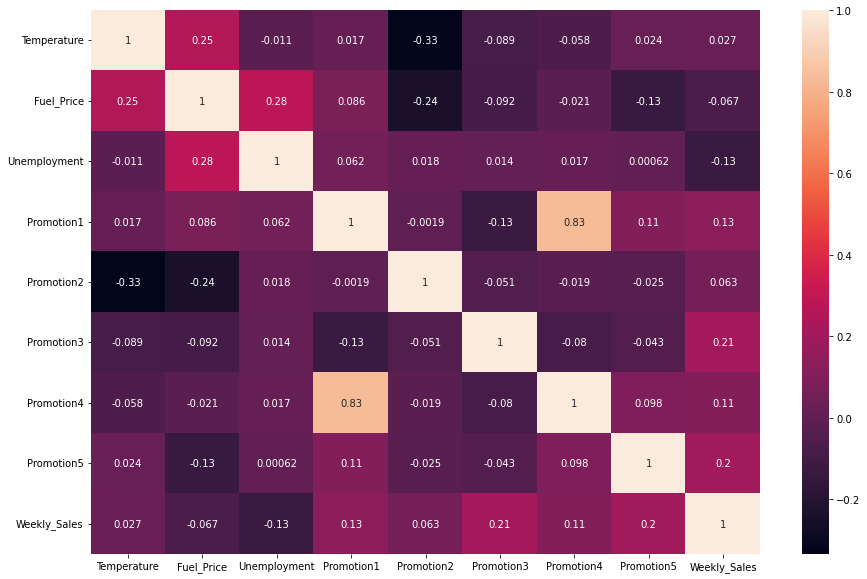

In [140]:
continuou = ['Temperature', 'Fuel_Price', 'Unemployment', 'Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']

plt.figure(figsize=(15,10))
ax = sns.heatmap(tem[continuou + ['Weekly_Sales']].corr(), annot=True)
plt.show()

연속형 변수간 상관관계와 매출액과에 상관관계를 알아보고자 합니다.

온도와 연료가격은 상관관계로 확인했을때는 별로 중요한 변수는 아닌걸로 판단됩니다.

다만 상관관계가 타겟변수를 예측하는데 절대적인 수치는 아닌 점을 고려하여 정말 필요가 없는 변수라면 모델에서 알아서 걸러지겠지라는 마인드로 그대로 사용합니다.

# 모델링

In [142]:
train = pd.get_dummies(train, columns = ['Store'])
test = pd.get_dummies(test, columns = ['Store'])
print(train.shape)
print(test.shape)
train.head()

(6255, 59)
(180, 58)


,id,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1,2010-05-02,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,...,0,0,0,0,0,0,0,0,0,0
1,2,2010-12-02,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,...,0,0,0,0,0,0,0,0,0,0
2,3,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,...,0,0,0,0,0,0,0,0,0,0
3,4,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,...,0,0,0,0,0,0,0,0,0,0
4,5,2010-05-03,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,...,0,0,0,0,0,0,0,0,0,0


앞서 언급한대로 매장별로 원핫인코딩을 수행합니다.

In [143]:
train_label = np.log1p(train['Weekly_Sales'])
train.drop(['Weekly_Sales', 'id', 'Date'], axis = 1, inplace = True)
test.drop(['id', 'Date'], axis = 1, inplace = True)

타겟변수를 로그변환하고 필요없는 변수를 제거합니다.

In [145]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 0, n_estimators = 100)
rf.fit(train,train_label)
sample_submission['Weekly_Sales'] = np.expm1(rf.predict(test))

sample_submission.to_csv('Sales1.csv',index=False)

간단한 렌덤포레스트 모델을 사용했습니다. 성능은 Public 기준 58454 정도 나오네요.

더 다양한 모델을 사용하거나 하이퍼파라미터 튜닝을 한다면 점수가 다소 오를 수 있습니다.

또 시도해볼만한 것은 시계열적 요소를 고려하면 좋을 것 같네요.

읽어주셔서 감사합니다.